---

# RAG Retrieval Evaluation

---

# 1. Overview and Objectives

This notebook presents the evaluation of a retrieval pipeline applied to financial earnings call transcripts. The objective is to measure how effectively the system can surface relevant factual content in response to natural-language questions.

The evaluation focuses on a curated set of twenty factual questions about Barclays’ Q3 2022 results. Performance is assessed using precision and recall, with controlled variation of key retrieval parameters (similarity threshold and per-document limits).

The scope is limited to the retrieval component of the wider RAG pipeline. By isolating retrieval, the results provide a reproducible, metric-based view of how parameter choices affect the accuracy and coverage of returned context.

The full project repository, including supporting scripts and results, is available on GitHub [here](https://github.com/nicolas-voltier/Dream_Team-Employeer_project). A summary of the input, output, and visual files referenced in this Notebook is provided in Appendix D.

_Note: All evaluations used gpt‑3.5 due to model instability; see Section 10.3 and Appendix C for details._

# 2. Corpus & Retrieval Pipeline




The evaluation corpus consists of 10 Barclays quarterly results Q&A transcripts spanning 2022 to 2025. These were selected for consistency, ingestion quality, and thematic cohesion. Transcripts from Citigroup and other banks were excluded to ensure clean alignment between questions and retrieved content.

A set of 20 factual questions was manually constructed from these documents. Each question:
- Has a known ground-truth answer.
- Is tagged as either simple (single fact) or compound (multi-fact).
- Is traceable to a specific document and page.

Questions focus on key financial topics such as net interest margin (NIM), RoTE, costs, buybacks, and capital returns. The goal is not completeness, but rather a controlled and traceable evaluation set. All questions were written manually using the commercial ChatGPT interface and without input from classical NLP tools or external PRA content.

The retrieval pipeline uses a Neo4j graph database to store and query facts. Each fact is embedded and linked to a page and document node within the graph schema. A `CORPUS` node controls filtering: for this evaluation, only documents tagged to the "Barclays" corpus were included.

Before evaluation, ingestion was confirmed using the Cypher query:

```cypher
MATCH (d:DOCUMENT) RETURN d
```

This returned 12 documents, of which only 10 (Barclays) were used for evaluation. We validated links via Neo4j Desktop to confirm correct graph structure.

At retrieval time:
- Questions are embedded using OpenAI’s `text-embedding-ada-002` model.
- Cosine similarities are calculated between question and fact embeddings.
- A Cypher query selects the top-k facts per document above a similarity threshold.

```cypher
MATCH (n:FACT)-[r]-(p:PAGE)-[]-(d:DOCUMENT)
WHERE n.embedding IS NOT NULL
WITH n, p, d,
     vector.similarity.cosine(n.embedding, $question_embedding) AS similarity_fact,
     vector.similarity.cosine(r.embedding, $question_embedding) AS similarity_page
WITH n, p, d, similarity_fact, similarity_page, (similarity_fact + similarity_page)/2 AS similarity
WHERE similarity > $threshold
ORDER BY similarity DESC
WITH d,
     [fact IN collect({fact: n.name, page: p.name, similarity: similarity}) | fact][..$limit] AS relevant_facts,
     max(similarity) AS max_similarity
RETURN d.name AS document_name, d.summary AS document_summary, relevant_facts, max_similarity
```

The retrieval logic is implemented in the `query_graph()` function inside `process_graph.py`, which handles embedding, Cypher execution, and postprocessing.

A standalone script (`test_neo4j_connection.py`) is available to verify database setup.

Retrieval steps are as follows:
1. User enters a query (Streamlit or CLI).
2. The query is embedded via `text-embedding-ada-002`.
3. Neo4j is queried for matching facts.
4. Similarities are ranked and filtered.
5. Top-k facts per document are returned.
6. These are optionally passed into a prompt template for downstream use.

This flow is deterministic and fully controlled via environment configuration.

# 3. Parameter Calibration

The retrieval pipeline uses two key parameters:

- **Similarity threshold (τ)** — filters out low-similarity facts.
- **Top-k limit** — caps the number of facts returned per document.

We fixed **top_k = 5**, which limits the number of retrieved facts from each document, preserving diversity and avoiding overload from any one source.

For τ, we explored values including **0.6, 0.7, and 0.9**, with full comparative results presented in Section 5. The threshold acts as a dial between precision and recall and is a central axis in evaluation design.

These parameters are passed through `query_graph()` and implemented in both `process_graph.py` and `ragas_builder.py`. The table below shows where each is set:

| Parameter | Default Value | Defined In           | Description |
|-----------|---------------|----------------------|-------------|
| threshold | varies (0.6–0.9) | `process_graph.py`   | Filters facts by average similarity |
| threshold | varies         | `ragas_builder.py`   | Passed per run to control strictness |
| top_k     | 5             | `process_graph.py`   | Applied per document in Cypher |
| top_k     | 5             | `ragas_builder.py`   | Passed per run to limit per-doc results |

These settings define the retrieval behaviour; their impact on precision and recall is assessed later.

# 4. Evaluation Setup and Parameters

This section defines the evaluation framework used across all runs. We assess retrieval-only performance using RAGAS `context_precision` and `context_recall`. Question sets are versioned datasets with known ground-truth answers, page links for traceability, and tags indicating whether a question is simple (single fact) or compound (multi-fact).

Reproducibility is maintained by fixing the code/graph snapshot and evaluation defaults (τ, top_k) for each run; corpus restriction via BANK_FILTER is recorded when applied.
Run parameters and artifacts are recorded alongside outputs, with full checklists held in the appendices.

## 4.1 Retrieval-Only Evaluation Scope

This project evaluates only the **retrieval** component of the RAG pipeline. We do **not** assess or generate final answers using a language model. Instead, we test whether the correct supporting **FACTs** (contexts) were retrieved for each question.

The evaluation follows the **retrieval-only metrics** provided by RAGAS. For a full list, see:  
https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/

From that list, we use only:
- `context_precision`
- `context_recall`

These metrics are designed for evaluating retrieval quality *without requiring generated answers*. We **do not use** metrics like `faithfulness`, `response_relevancy`, or `context_entities_recall`, as they require the `answer` field and apply only to generative setups.

In our setup:
- `question` = the user question
- `contexts` = the retrieved FACTs (limited to DOC_LIMIT × TOP_K = 15)
- `ground_truth` = the expected factual answer (manually labelled)
- `answer` = not used

In plain terms:
- `context_precision` measures the **fraction of retrieved contexts that support the answer**
- `context_recall` measures the **fraction of ground truth claims that were supported by retrieval**

Formal equations and metric weighting details are provided in the Appendix.

This setup isolates retrieval performance from generation, allowing us to evaluate whether the correct supporting contexts were retrieved without interference from LLM output.

## 4.2 Controlling Evaluation Scope by Bank

This control constrains retrieval and evaluation to a single bank’s corpus so that answers cannot leak in from unrelated documents. Questions in the input sheet carry a `Bank` tag, the evaluation builder can filter rows by setting `BANK_FILTER` (for example, `BANK_FILTER = "Barclays"`), and the retriever enforces the same scope by adding a corpus/bank predicate inside `query_graph()` so results cannot drift across banks.

## 4.3 Retrieval Scope Constraint (DOC_LIMIT × TOP_K)

To prevent excessive or diluted context retrieval, we apply a cap on the number of documents and facts retrieved per question. This cap is defined as:

- **TOP_K**: maximum number of facts retrieved *per document*
- **DOC_LIMIT**: maximum number of *documents* retrieved per question

In our stress-test evaluation runs, this results in a maximum of 15 contexts per question (3 documents × 5 facts).

The cap is defined in `ragas_builder.py` as part of the run configuration:

```python
# Config (stress-test run)
INPUT_FILE  = "data/Stress-Test_Questions.xlsx"
OUTPUT_FILE = "stress_test_ragas_input.jsonl"
THRESHOLD   = 0.6          # similarity gate (τ)
TOP_K       = 5            # max facts per document
DOC_LIMIT   = 3            # max documents per question
BANK_FILTER = "Barclays"   # restrict corpus; None disables
```

It is passed into the retrieval call when building the question-context dataset:

```python
raw_output = await gp.query_graph(
    question=q["question"],
    top_k=TOP_K,
    doc_limit=DOC_LIMIT,
    ...
)
```

The enforcement occurs inside `process_graph.py`, where the `doc_limit` value is injected directly into the Cypher query that selects documents from the graph:

```python
doc_limit_clause = f"\nORDER BY max_similarity DESC\nLIMIT {doc_limit}\n"
query += doc_limit_clause
```

This ensures that even if many documents contain relevant matches, only the top-ranked documents (by similarity) are retained for evaluation. The result is a consistent, interpretable retrieval budget per question — avoiding earlier problems where 12+ documents each contributed 5 facts (60+ total contexts). With this cap, we gain control over retrieval scope and make RAGAS precision/recall metrics easier to interpret.

## 4.4 Reproducibility Notes

All experiments were executed on the same codebase and graph snapshot to keep results comparable. Environment variables were loaded from `.env`; no ad‑hoc overrides were used during scored runs. Defaults for threshold (τ), `top_k` (per document), and any `BANK_FILTER` setting were fixed at the start of each run and not altered mid‑run. The question datasets (stress 3, Barclays 20) were treated as versioned inputs and not edited after a run began. Where model/runtime stability issues were encountered, the final, working configuration is stated in the relevant run section so the outcome can be reproduced without further tuning.

## 4.5 Per-Run Logging

For each run we record: run timestamp (UTC), question file and version, corpus/bank filter, τ, `top_k`, embedding model and version, and output file paths (JSON/JSONL/MD). We also record any model/runtime anomalies (timeouts, retries, wrapper overrides) and any deviations from the default configuration. These items appear at the end of each run section so that the parameters and artifacts sit beside the results they produced.

# 6. Stress Test: Out-of-Scope Questions

In earlier stages of evaluation, it became evident that the RAG agent was capable of answering nearly all concrete factual questions derived from the corpus. To test the limits of the system, we explored a new evaluation angle: assessing the RAG pipeline's performance when faced with questions for which no matching fact exists in the graph.

This stress-testing approach is designed to evaluate the agent's ability to handle situations where explicit retrieval is not possible, and to observe whether it can reason from indirect signals, acknowledge uncertainty, or avoid hallucinating unsupported claims.

## 6.1 Selection of Document

The document `Barclays_2022_Q3_ResultsQA_Transcript.pdf` was selected for this experiment. It contains 153 facts, each of which appears **only once** across the full graph database. This made it a clean candidate for stress testing, as any question whose answer does not appear within those facts is definitively out of scope for fact-based retrieval.

Unlike the main evaluation process, which allows filtering by bank using the `BANK_FILTER` variable, we chose **not to add any explicit document-level filtering** for the stress-test questions. This was intentional: we wanted to assess whether the RAG system could still retrieve relevant content from a specific document (Barclays Q3 2022) without any structural hints in the retrieval pipeline.

Instead, we embedded temporal cues — e.g. “Q3 2022” — directly into the question wording. This nudges the retriever toward the intended document without modifying code or indexing logic. While not a perfect control, it simulates a real-world scenario where users may reference time periods but not specific file names. This keeps the test realistic while still focused on a known document.

We validated that all facts in this document are unique and do not appear elsewhere in the corpus, ensuring a clean boundary for stress-testing.

To identify a suitable document for stress testing, we explored the distribution of facts across the Barclays corpus using a series of Cypher queries.

First, we verified whether any facts were duplicated across documents:

```cypher
MATCH (d:DOCUMENT)-[:PART_OF]->(:CORPUS {name: "Barclays"})
MATCH (d)-[:CONTAINS]->(:PAGE)<-[:QUESTION]-(f:FACT)
RETURN f.name AS fact_text, count(*) AS occurrences
ORDER BY occurrences DESC, fact_text
```

Then, we retrieved only the facts that appeared **more than once**, and listed the documents they occurred in:

```cypher
MATCH (d:DOCUMENT)-[:PART_OF]->(:CORPUS {name: "Barclays"})
MATCH (d)-[:CONTAINS]->(:PAGE)<-[:QUESTION]-(f:FACT)
WITH f.name AS fact_text, collect(DISTINCT d.name) AS documents, count(*) AS occurrences
WHERE occurrences > 1
RETURN fact_text, occurrences, documents
ORDER BY occurrences DESC, fact_text
```

We compared these results against a full list of documents in the Barclays corpus:

```cypher
MATCH (d:DOCUMENT)-[:PART_OF]->(:CORPUS {name: "Barclays"})
RETURN d.name AS all_documents
ORDER BY d.name
```

From this comparison, we identified `Barclays_2022_Q3_ResultsQA_Transcript.pdf` as the only document in which **every fact appears exactly once** across the entire graph. We confirmed this with:

```cypher
MATCH (d:DOCUMENT {name: "Barclays_2022_Q3_ResultsQA_Transcript.pdf"})
MATCH (d)-[:CONTAINS]->(:PAGE)<-[:QUESTION]-(f:FACT)
RETURN f.name AS fact_text, count(*) AS occurrences
ORDER BY occurrences DESC
```

Finally, we extracted the full list of facts for this document to ensure it would be suitable for the stress-test task:

```cypher
MATCH (d:DOCUMENT {name: "Barclays_2022_Q3_ResultsQA_Transcript.pdf"})
MATCH (d)-[:CONTAINS]->(:PAGE)<-[:QUESTION]-(f:FACT)
RETURN f.name AS fact
ORDER BY f.name
```

This workflow confirmed a clean, isolated fact set with no duplicates — making this document ideal for testing whether the system can answer **questions that fall outside any known fact**.



## 6.2 Selected Questions

The three stress-test questions (each intentionally outside the extracted fact set) are listed with their originating category and the expected “negative/omission” ground truth.

| Category                  | Question                                                                                       | Expected Answer                                                                 | Page(s)                            |
|---------------------------|------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------|-------------------------------------|
| Sentiment / Interpretation | What were the overall market or investor reactions to Barclays' Q3 2022 results presentation? | No market or investor sentiment is discussed in the document.                   | All pages                          |
| Intent / Reasoning        | Why did Barclays choose to increase investment in technology platforms during a period of cost inflation? | No rationale is provided, despite mentions of tech investment and cost pressures. | Spread across document              |
| Contextual Gaps / Omissions | Was there any discussion around ESG (Environmental, Social, and Governance) factors or sustainability initiatives? | ESG is not mentioned at all in the document.                                    | Entire document                     |

## 6.3 Purpose of Stress Testing

These questions are intended to probe whether the RAG agent:
- Can recognise when an answer is not available in the source
- Avoids hallucination
- Attempts indirect synthesis from surrounding context
- Indicates uncertainty where appropriate

They are also suitable for use in downstream RAGAS evaluation, allowing us to score performance when traditional recall-based metrics are no longer meaningful.

## 6.4 Final Results and Interpretation

We treat the Q3‑2022 Barclays results Q&A transcript as a closed fact set (153 unique facts). To probe failure behaviour without drifting into non‑extractive territory, we asked three deliberately out‑of‑scope questions: market/investor reaction, a “why” rationale for technology investment, and ESG/sustainability. Evaluation is retrieval‑only with RAGAS (`context_precision`, `context_recall`). Retrieval was constrained to avoid fan‑out so that interpretation remains clear: **DOC_LIMIT × TOP_K = 3 × 5 ⇒ up to 15 contexts per question**.

To make the run parameters explicit without breaking the flow, the configuration is summarised in a compact table inline:

| Parameter | Value | Notes |
|---|---:|---|
| THRESHOLD (τ) | 0.60 | Similarity gate for candidate facts |
| TOP_K | 5 | Max facts per document |
| DOC_LIMIT | 3 | Max documents per question |
| BANK_FILTER | Barclays | Restricts corpus to Barclays |
| max_contexts / question | 15 | DOC_LIMIT × TOP_K |

With this setup, the stress‑test results are as follows. The scores show zero precision across the board, as expected for questions whose answers are absent from the Q3‑2022 transcript. Recall differs depending on whether the negative ground truth is contradicted by retrieval.

| # | Question (short) | Ground truth (short) | Retrieved (n) | Precision | Recall |
|---:|---|---|---:|---:|---:|
| 1 | Market / investor reaction? | Not mentioned in Q3‑2022 | 15 | 0.00 | 1.00 |
| 2 | Why increase tech investment? | No rationale provided | 15 | 0.00 | 0.00 |
| 3 | Any ESG discussion? | Not mentioned in Q3‑2022 | 15 | 0.00 | 1.00 |

The retrieved contexts largely came from later periods (2023–2024) rather than the target Q3‑2022 call, which explains both the collapse in precision and the recall pattern. For completeness, we provide a brief reading guide for omission/negation questions so the marker understands why recall can be high without any supporting evidence.

| Situation | What RAGAS credits | What it means here |
|---|---|---|
| Ground truth is “not mentioned” and retrieval does **not contradict** | Higher `context_recall` | Q1 and Q3 score 1.00 recall despite zero precision |
| Ground truth is “not mentioned” but retrieval doesn’t align or help | `context_recall` can be 0.00 | Q2 shows 0.00 recall (no aligned rationale; off‑period text) |
| No supporting evidence in the source doc | `context_precision = 0.00` | All three questions: expected for out‑of‑scope asks |


### Clarifying recall behaviour for “not mentioned” answers

These results may appear counterintuitive: recall scores of **1.00** despite no supporting facts. This happens because the **ground truth itself is negative** — it asserts that the answer is *not present* in the document. In this context, RAGAS awards recall not for support, but for **avoiding contradiction**.

- For Q1 and Q3, the retrieved material **did not conflict** with the absence of an answer, so recall is 1.00.
- For Q2, the retrieved texts were temporally misaligned (from later periods) and failed to address the rationale, so recall is 0.00.

Thus, in omission/negation cases, recall reflects **non-contradiction** — not evidence. High recall means the retriever stayed silent where appropriate; low recall means it wandered into off-topic or incompatible ground.

### Interpretation

Precision is 0.00 for all questions, confirming there is no accidental support for these out‑of‑scope asks within the Q3‑2022 transcript. Recall, in this omission/negation setting, must be interpreted carefully: it reaches 1.00 for the market/investor reaction and ESG questions because the retrieval does not contradict the negative ground truths, but falls to 0.00 for the “why” rationale where nothing aligned or corroborated the negative answer. The dominant failure mode is **temporal drift** — passages from 2023–2024 were retrieved for questions scoped to 2022. This can be addressed by constraining retrieval by document or time slice.

_Note: These results are artefacts of RAGAS’s internal scoring logic. While valid within that framework, they do not imply human-meaningful recall and should be interpreted cautiously._

# 7. Barclays 20-Question Evaluation

## 7.1 Evaluation Overview

This section evaluates retrieval quality for twenty Barclays questions using the two context-only metrics adopted in the Employer Project: **context_precision** and **context_recall**. To ensure comparability with earlier experiments, we fixed the retriever parameters as follows: `top_k = 5`, `doc_limit = 3`, and `bank_filter = Barclays`, using the RAGAS default model (`ChatOpenAI`, i.e. `gpt-3.5-turbo`).

Each run produced timestamped outputs and a corresponding script snapshot to ensure reproducibility. Full experiment artefacts are available in the GitHub repository (`results_rag_retrieval/barclays_20q`).

## 7.2 Threshold Settings and Run Configurations

Two runs were performed using different similarity thresholds (τ), which control how strictly the retriever filters potentially relevant evidence:

- **Run A (τ = 0.6)**: A moderate threshold expected to balance precision and recall.
- **Run B (τ = 0.9)**: A stricter threshold expected to reduce noise, at the risk of omitting useful content.

The same retriever parameters and reference-answer sets were used for both runs to preserve strict comparability.

## 7.3 Evaluation Results

### 7.3.1 Aggregate Metrics

| Threshold (τ) | Context Precision | Context Recall |
|---------------|-------------------|----------------|
| 0.6           | 0.4567            | 0.4750         |
| 0.9           | 0.0000            | 0.8000         |

The τ = 0.6 run achieved a balanced performance, with roughly half of the retrieved material being relevant and nearly half of the reference information recovered. In contrast, τ = 0.9 completely collapsed precision, indicating most questions retrieved no context at all. The high recall at τ = 0.9 is an artefact of RAGAS’ internal scoring and not a sign of successful retrieval.

### 7.3.2 Per-Question Results

Figures 1 and 2 show the context_precision and context_recall scores for all 20 questions, sorted by average score.

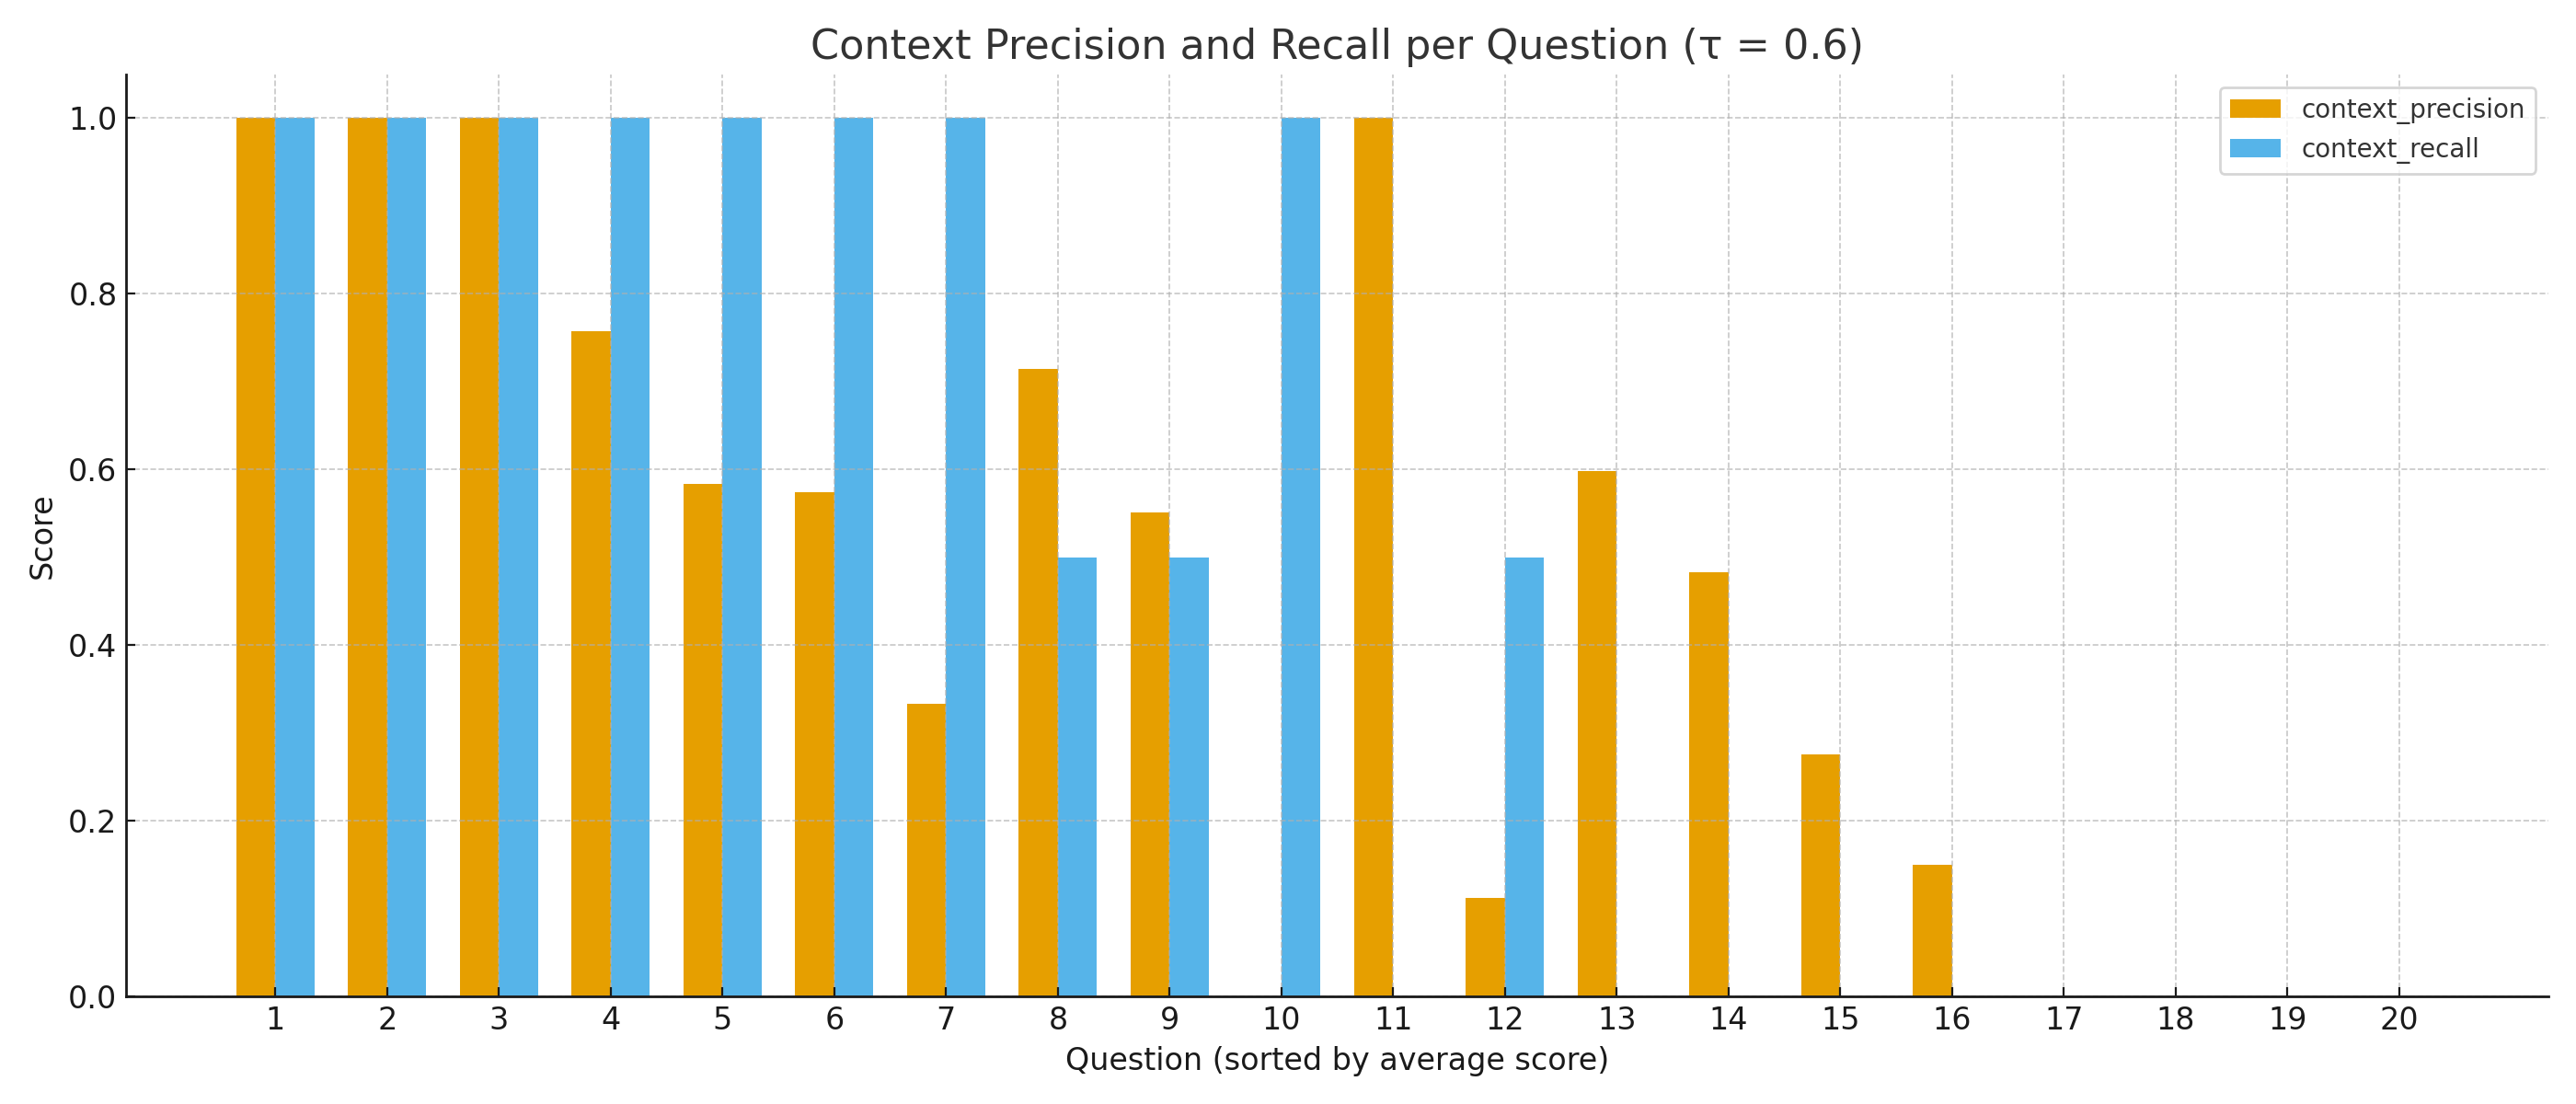

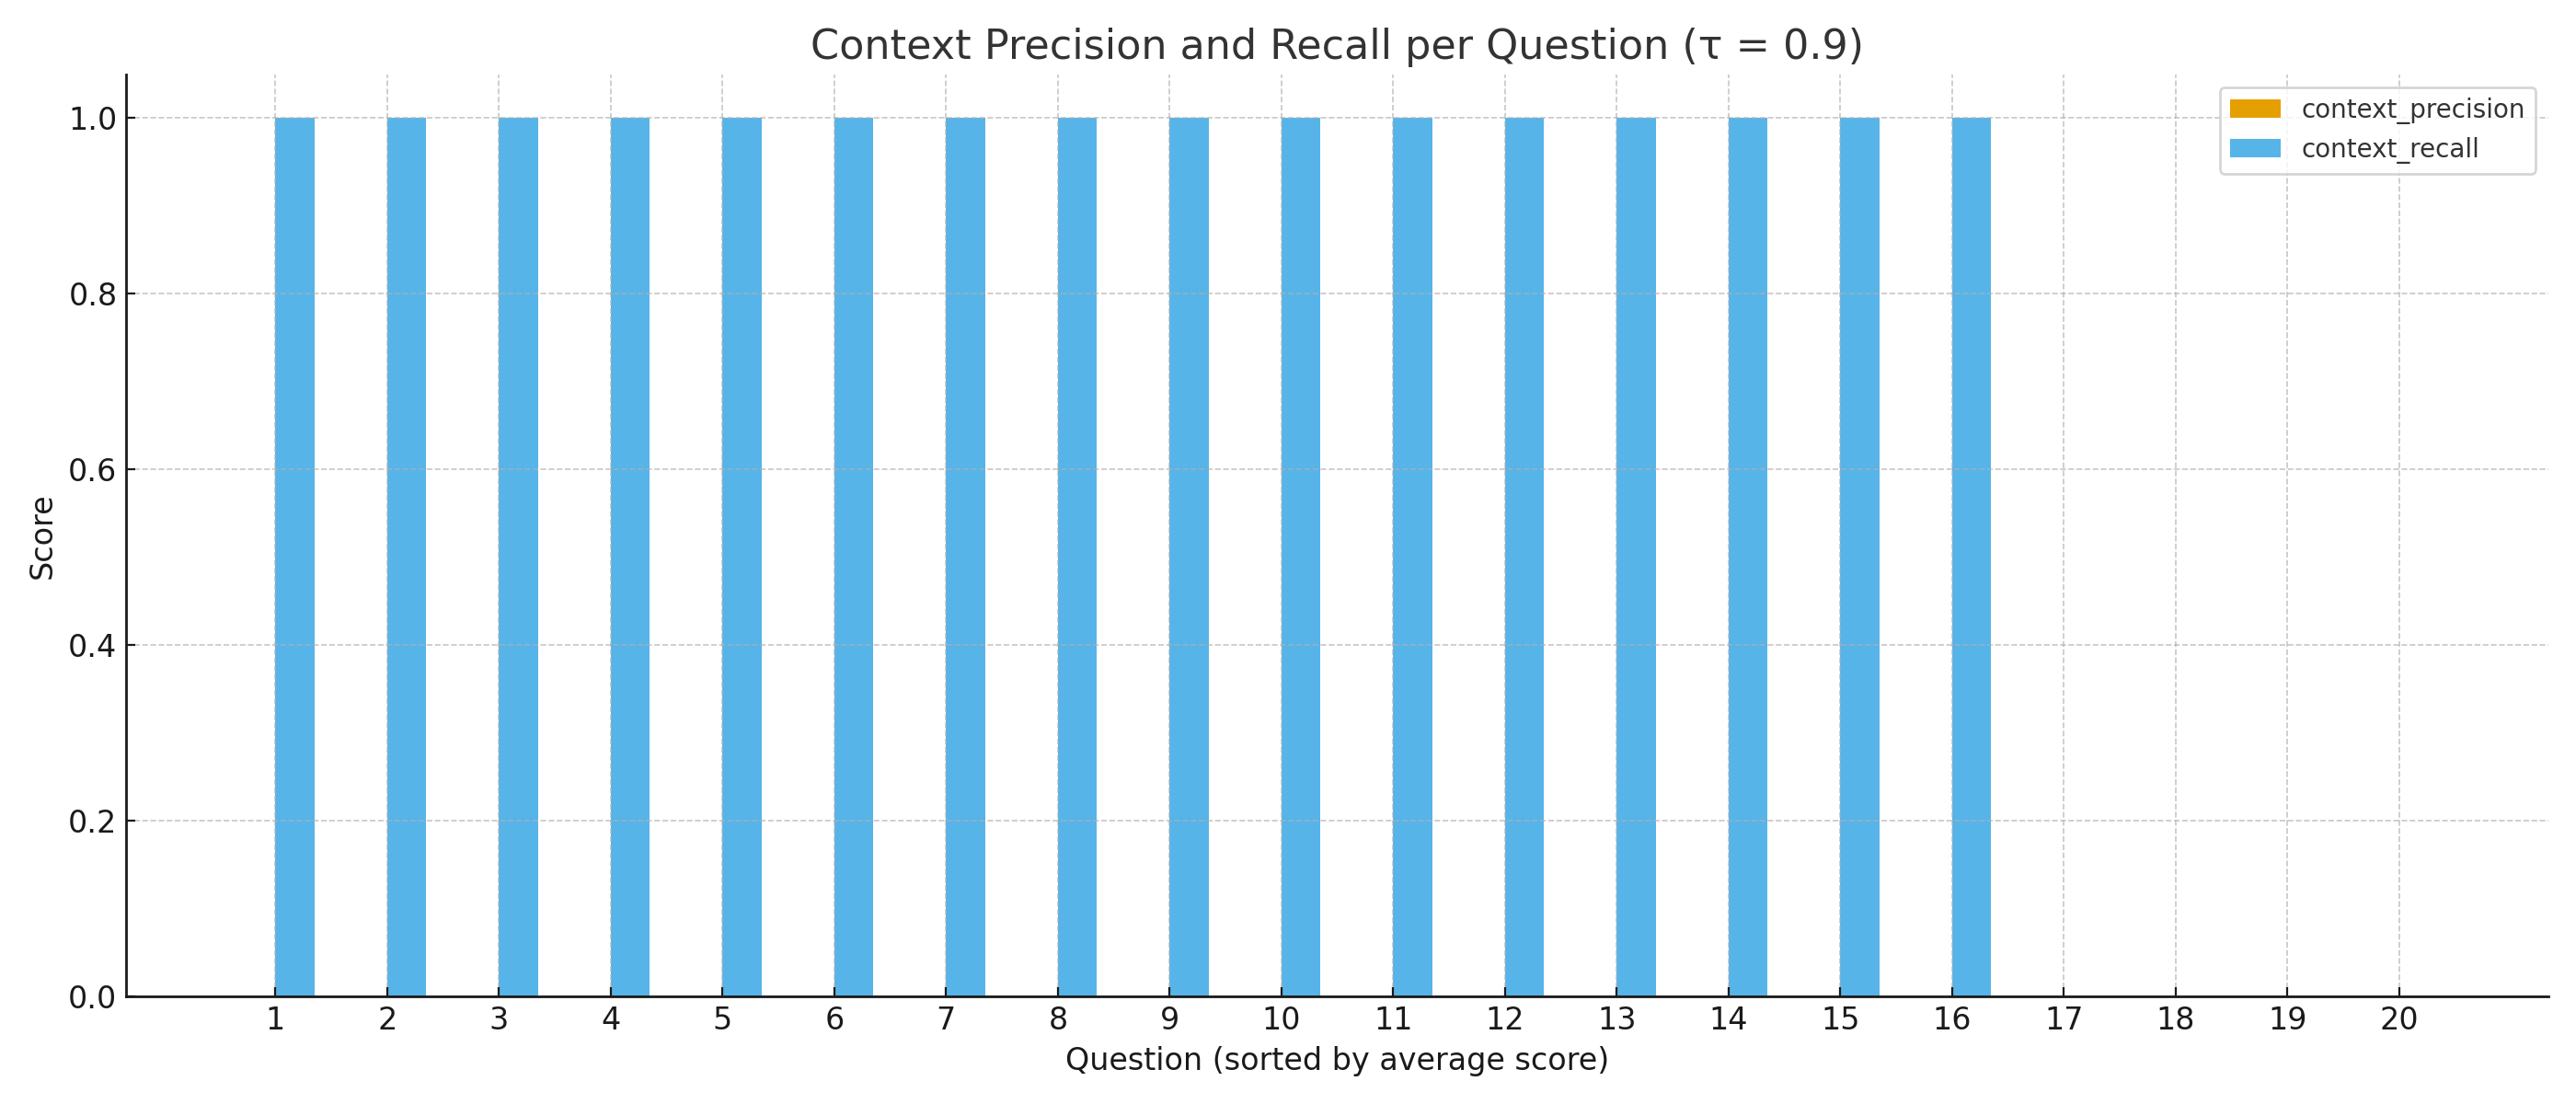

In [1]:
from IPython.display import Image, display
display(Image(filename='barclays20q_precision_recall_tau_06.png'))  # Figure 1
display(Image(filename='barclays20q_precision_recall_tau_09.png'))  # Figure 2

#### Full results for τ = 0.6:

| No. | Precision | Recall | Question (abridged) |
|-----|-----------|--------|----------------------|
| 1   | 0.598     | 0.0    | Why did CET1 end 2022 at 13.9% and what immediately used ~40bps i… |
| 2   | 0.483     | 0.0    | What drove the −33bps “Other” hit to BUK NIM in Q4-22? |
| 3   | 0.574     | 1.0    | Did Barclays guide BUK NIM “>3.20%” for 2023 and why? |
| 4   | 0.758     | 1.0    | How did UK card behaviour affect impairments in Q1-23? |
| 5   | 0.0       | 0.0    | What was the stance on AT1 calls in 2023? |
| 6   | 1.0       | 1.0    | By mid-2023, was Barclays still asset-sensitive to rate hikes? |
| 7   | 0.15      | 0.0    | How were UK deposits behaving in mid-2023? |
| 8   | 0.333     | 1.0    | Why did BUK NIM guidance widen in Q3-23? |
| 9   | 0.0       | 0.0    | Did planned restructuring jeopardise capital returns at 2023 year… |
| 10  | 0.112     | 0.5    | Were UK deposits stabilising by Q1-24? |
| 11  | 1.0       | 1.0    | Did the 2024 US late-fee rule sit inside guidance? |
| 12  | 0.276     | 0.0    | What’s the path to >12% NIM in US Consumer? |
| 13  | 0.0       | 1.0    | 2024 H1 upgrade: what were the new NII guides? |
| 14  | 1.0       | 0.0    | Why was product margin positive in Q3-24? |
| 15  | 0.0       | 0.0    | What were the 2025 BUK NII building blocks? |
| 16  | 1.0       | 1.0    | How much of US cards receivables are “locked” and what’s the mark… |
| 17  | 0.552     | 0.5    | Why did USCB impairment include a PMA in Q1-25? |
| 18  | 0.715     | 0.5    | Does SRT financing in the FCA ‘Dear CFO’ letter affect Barclays? |
| 19  | 0.0       | 0.0    | How much structural hedge income was locked-in by mid-2024? |
| 20  | 0.583     | 1.0    | What’s the planning framework for hedge rolls to 2026? |


#### Full results for τ = 0.9:

| No. | Precision | Recall | Question (abridged) |
|-----|-----------|--------|----------------------|
| 1   | 0.000     | 1.000  | Why did CET1 end 2022 at 13.9% and what immediately used ~40bps i… |
| 2   | 0.000     | 1.000  | What drove the −33bps “Other” hit to BUK NIM in Q4-22? |
| 3   | 0.000     | 1.000  | Did Barclays guide BUK NIM “>3.20%” for 2023 and why? |
| 4   | 0.000     | 1.000  | How did UK card behaviour affect impairments in Q1-23? |
| 5   | 0.000     | 1.000  | What was the stance on AT1 calls in 2023? |
| 6   | 0.000     | 0.000  | By mid-2023, was Barclays still asset-sensitive to rate hikes? |
| 7   | 0.000     | 0.000  | How were UK deposits behaving in mid-2023? |
| 8   | 0.000     | 1.000  | Why did BUK NIM guidance widen in Q3-23? |
| 9   | 0.000     | 0.000  | Did planned restructuring jeopardise capital returns at 2023 year… |
| 10  | 0.000     | 1.000  | Were UK deposits stabilising by Q1-24? |
| 11  | 0.000     | 1.000  | Did the 2024 US late-fee rule sit inside guidance? |
| 12  | 0.000     | 1.000  | What’s the path to >12% NIM in US Consumer? |
| 13  | 0.000     | 0.000  | 2024 H1 upgrade: what were the new NII guides? |
| 14  | 0.000     | 1.000  | Why was product margin positive in Q3-24? |
| 15  | 0.000     | 1.000  | What were the 2025 BUK NII building blocks? |
| 16  | 0.000     | 1.000  | How much of US cards receivables are “locked” and what’s the mark… |
| 17  | 0.000     | 1.000  | Why did USCB impairment include a PMA in Q1-25? |
| 18  | 0.000     | 1.000  | Does SRT financing in the FCA ‘Dear CFO’ letter affect Barclays? |
| 19  | 0.000     | 1.000  | How much structural hedge income was locked-in by mid-2024? |
| 20  | 0.000     | 1.000  | What’s the planning framework for hedge rolls to 2026? |

# 8. Threshold Optimisation Strategy

The τ = 0.6 and τ = 0.9 evaluations revealed that retrieval performance is highly sensitive to the similarity threshold. At τ = 0.6, roughly half of the retrieved content was relevant, while at τ = 0.9, most questions returned empty contexts. These extremes bracket the performance spectrum, indicating that a more effective threshold likely lies in between.

Our goal is to identify a similarity threshold that filters noisy matches without eliminating useful evidence. This section explores how to select a better value.

## 8.1 Similarity Score Distributions

To guide the selection of the next threshold value (τ), we analysed the distribution of similarity scores in the JSONL input file used for the τ = 0.6 run. Each retrieved chunk includes a similarity score reflecting its semantic closeness to the question. These scores determine whether a passage is retained or filtered when applying a threshold during question-to-context matching.

We extracted the **Top-1** and **Top-3** similarity scores across all 20 questions and plotted their distributions. These reflect the strongest and third-strongest matches available per question. Understanding where these scores lie allows us to assess what percentage of relevant passages would survive under stricter thresholds like τ = 0.65, τ = 0.70, or τ = 0.75.

To generate the plot, we used the following code:

In [3]:
import json

with open("barclays_20_input_tau_0.6.jsonl", "r") as f:
    data = [json.loads(line) for line in f]


In [12]:
top1 = [q["contexts_meta"][0]["similarity"] for q in data]
top3 = [q["contexts_meta"][2]["similarity"] for q in data if len(q["contexts_meta"]) >= 3]

# print(type(top1))
# print(type(top3))

We then plotted the distributions using matplotlib:

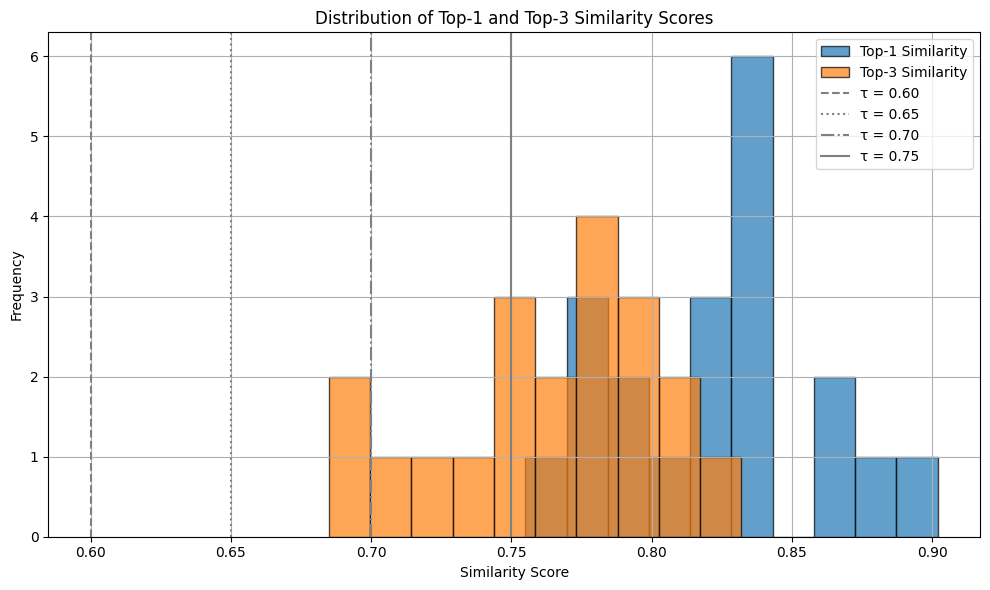

In [13]:
import matplotlib.pyplot as plt

def plot_similarity_distributions(top1, top3):
    plt.figure(figsize=(10, 6))
    plt.hist(top1, bins=10, alpha=0.7, label='Top-1 Similarity', color='tab:blue', edgecolor='black')
    plt.hist(top3, bins=10, alpha=0.7, label='Top-3 Similarity', color='tab:orange', edgecolor='black')
    plt.axvline(x=0.6, color='grey', linestyle='--', label='τ = 0.60')
    plt.axvline(x=0.65, color='grey', linestyle=':', label='τ = 0.65')
    plt.axvline(x=0.70, color='grey', linestyle='-.', label='τ = 0.70')
    plt.axvline(x=0.75, color='grey', linestyle='-', label='τ = 0.75')
    plt.xlabel("Similarity Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of Top-1 and Top-3 Similarity Scores")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_similarity_distributions(top1, top3)


Histogram of similarity scores for top-1 and top-3 retrieved chunks across all 20 questions. Vertical lines indicate candidate thresholds under consideration for the next run. A substantial number of top matches fall between 0.70 and 0.80, suggesting that τ values higher than 0.75 would begin to filter even strong candidates. τ = 0.9, by contrast, would eliminate nearly all top-3 results.

In [14]:
# Define candidate thresholds
thresholds = [0.60, 0.65, 0.70, 0.75, 0.80, 0.85]

# Initialise results list
results = []

# Loop over thresholds and count matches
for tau in thresholds:
    top1_count = sum(s >= tau for s in top1)
    top3_count = sum(s >= tau for s in top3)
    results.append((tau, top1_count, top3_count))

# Print results as a table
print(f"{'Threshold (τ)':<15}{'Top-1 ≥ τ':<12}{'Top-3 ≥ τ'}")
for tau, t1, t3 in results:
    print(f"{tau:<15}{t1:<12}{t3}")


Threshold (τ)  Top-1 ≥ τ   Top-3 ≥ τ
0.6            20          20
0.65           20          20
0.7            20          18
0.75           20          14
0.8            14          3
0.85           4           0


Top-1 similarity is consistently strong up to **τ = 0.75** — all 20 questions survive.

Top-3 similarity starts to drop sharply above **τ = 0.70**, indicating a risk of retrieval gaps for multi-part or harder questions.

At **τ = 0.80**, 6 questions have no strong top-1 match, and 17 have no top-3 match — far too harsh.

### 🎯 Recommendation

The best candidate for the next run is:

**τ = 0.70**

This value retains top-1 matches for all questions, but begins to apply real pressure on the less-similar chunks (reflected in the drop from 20 → 18 in top-3). This should improve precision by filtering noise, without sacrificing retrieval coverage for more complex questions.

We will test τ = 0.70 in the next run, keeping all other parameters fixed to maintain strict comparability with Runs A and B.

## 8.2 Final Threshold Run (τ = 0.70)

Based on the similarity-score distribution, we selected **τ = 0.70** as the most promising candidate for the final run. This value was expected to strike a balance — stricter than τ = 0.60 but not as severe as τ = 0.90 — potentially retaining strong top matches while filtering weaker noise.

The RAGAS evaluation for τ = 0.70 yielded the following results:

| Metric              | Value   |
|---------------------|---------|
| **context_precision** | 0.4843  |
| **context_recall**    | 0.5000  |

This run slightly improved both metrics over τ = 0.60, however, the gains are marginal and fall short of a clear breakthrough.

When comparing all three runs:

| Run | Threshold (τ) | Precision | Recall  |
|-----|---------------|-----------|---------|
| A   | 0.60          | 0.4567    | 0.4750  |
| B   | 0.90          | 0.0000    | 0.8000* |
| C   | 0.70          | 0.4843    | 0.5000  |

> *Recall at τ = 0.90 is misleading: most questions returned empty contexts, and RAGAS may still infer partial overlaps based on the answer text.

These results show that threshold tuning helps — but only up to a point. Even at the best setting, only half the content retrieved is relevant. To go further, we'd likely need broader search (e.g. raising the document or chunk limit), smarter retrieval logic (beyond just surface similarity), or a stronger language model that can do more with limited input. We also suspect that question complexity plays a major role: the system may perform much better on simple, single-fact queries than on compound ones. This possibility is explored in the next Section.

#### Full results for τ = 0.70:

| No. | Precision | Recall | Question (abridged) |
|-----|-----------|--------|----------------------|
| 1   | 0.598     | 0.000  | Why did CET1 end 2022 at 13.9% and what immediately used ~40bps in Q1? |
| 2   | 0.483     | 1.000  | What drove the “Other” hit to BUK NIM in Q4-22? |
| 3   | 0.574     | 1.000  | Did Barclays guide BUK NIM “>3.20%” for 2023 and why? |
| 4   | 0.758     | 1.000  | How did UK card behaviour affect impairments in Q1-23? |
| 5   | 0.000     | 0.000  | What was the stance on AT1 calls in 2023? |
| 6   | 1.000     | 1.000  | By mid-2023, was Barclays still asset-sensitive to rate hikes? |
| 7   | 0.067     | 0.000  | How were UK deposits behaving in mid-2023? |
| 8   | 0.333     | 1.000  | Why did BUK NIM guidance widen in Q3-23? |
| 9   | 0.000     | 0.000  | Did planned restructuring jeopardise capital returns at 2023 year-end? |
| 10  | 0.112     | 0.500  | Were UK deposits stabilising by Q1-24? |
| 11  | 1.000     | 1.000  | Did the 2024 US late-fee rule sit inside guidance? |
| 12  | 0.276     | 0.000  | What’s the path to >12% NIM in US Consumer? |
| 13  | 0.000     | 1.000  | 2024 H1 upgrade: what were the new NII guides? |
| 14  | 1.000     | 0.000  | Why was product margin positive in Q3-24? |
| 15  | 0.000     | 0.000  | What were the 2025 BUK NII building blocks? |
| 16  | 1.000     | 1.000  | How much of US cards receivables are “locked” and what’s the market size? |
| 17  | 0.771     | 0.000  | Why did USCB impairment include a PMA in Q1-25? |
| 18  | 0.715     | 0.500  | Does SRT financing in the FCA ‘Dear CFO’ letter affect Barclays? |
| 19  | 0.000     | 0.000  | How much structural hedge income was locked-in by mid-2024? |
| 20  | 1.000     | 1.000  | What’s the planning framework for hedge rolls to 2026? |



### ⚠️ Generalisability and Overfitting

While τ = 0.70 emerged as the best-performing threshold on this specific 20-question set, this result should not be over-interpreted. All evaluations were tuned to a single dataset, and even the best-performing configuration may be **overfitted to this particular set of questions**. In production, performance will depend heavily on the nature of incoming queries — especially their complexity, domain specificity, and matchability to indexed passages.

To mitigate this, future work should include:

- Broader and more diverse test sets (e.g. multiple earnings calls, multiple banks)
- Evaluation across question types (as begun in §5.6)
- Live testing with real user queries

The current results are **indicative**, not definitive.

# 9. Impact of Question Complexity

To explore whether question complexity might influence retrieval performance, we classified each of the 20 evaluation questions as either **Simple** or **Compound**, based solely on the structure of the question itself.

We then ran a few lightweight checks using the τ = 0.70 results:

1. **Group-level averages**  
   We compared mean `context_precision` and `context_recall` for Simple vs Compound questions.  
   _Rationale:_ Compound questions might underperform due to being multi-part — or, conversely, help retrieval by offering richer phrasing.

2. **Failure frequency**  
   We counted how often questions in each group received a precision or recall score of zero.  
   _Rationale:_ This flags complete retrieval failure and whether it’s more common for one group.

3. **Retrieval consistency**  
   We used `.describe()` to summarise variance across each group.  
   _Rationale:_ Even if averages are similar, one group may behave more erratically.

## 9.1 Defining Question Complexity

To assess whether question formulation impacts retrieval performance, each of the 20 evaluation questions was classified as either **Simple** or **Compound**.

This classification was done **based solely on the form of the question**, not the length or structure of the answer. The rule applied was:

> A question is **Compound** if it explicitly asks for more than one distinct piece of information (e.g., includes an 'and', multiple clauses, or enumerates components). Otherwise, it is **Simple**.

This approach reflects a retrieval-first perspective: could a better-worded or more focused question improve retrieval? It avoids hindsight bias from the answer content.

### Final classification used

| Q# | Question                                                                  | Type     | Justification                                                  |
| -: | ------------------------------------------------------------------------- | -------- | -------------------------------------------------------------- |
|  1 | Why did CET1 end 2022 at 13.9% and what immediately used ~40bps in Q1?    | Compound | Two distinct asks: (i) reason for 13.9%, (ii) what used 40bps. |
|  2 | What drove the −33bps “Other” hit to BUK NIM in Q4-22?                    | Simple   | Single causal “what drove” question.                           |
|  3 | Did Barclays guide BUK NIM “>3.20%” for 2023 and why?                     | Compound | Yes/no check **and** explanatory clause.                       |
|  4 | How did UK card behaviour affect impairments in Q1-23?                    | Simple   | One relationship: card behaviour → impairments.                |
|  5 | What was the stance on AT1 calls in 2023?                                 | Simple   | One policy summary.                                            |
|  6 | By mid-2023, was Barclays still asset-sensitive to rate hikes?            | Simple   | Single yes/no financial condition check.                       |
|  7 | How were UK deposits behaving in mid-2023?                                | Simple   | One descriptive “how” prompt.                                  |
|  8 | Why did BUK NIM guidance widen in Q3-23?                                  | Simple   | One explanation asked for.                                     |
|  9 | Did planned restructuring jeopardise capital returns at 2023 year-end?    | Simple   | One yes/no judgment.                                           |
| 10 | Were UK deposits stabilising by Q1-24?                                    | Simple   | Single yes/no check.                                           |
| 11 | Did the 2024 US late-fee rule sit inside guidance?                        | Simple   | Single yes/no check.                                           |
| 12 | What’s the path to >12% NIM in US Consumer?                               | Simple   | One strategy-focused question.                                 |
| 13 | 2024 H1 upgrade: what were the new NII guides?                            | Simple   | One data-point request.                                        |
| 14 | Why was product margin positive in Q3-24?                                 | Simple   | One explanatory clause.                                        |
| 15 | What were the 2025 BUK NII building blocks?                               | Compound | Enumerative structure: asking for parts of a model.            |
| 16 | How much of US cards receivables are “locked” and what’s the market size? | Compound | Two numerical asks: locked %, market size.                     |
| 17 | Why did USCB impairment include a PMA in Q1-25?                           | Simple   | One explanatory clause.                                        |
| 18 | Does SRT financing in the FCA ‘Dear CFO’ letter affect Barclays?          | Simple   | One yes/no ask.                                                |
| 19 | How much structural hedge income was locked-in by mid-2024?               | Simple   | One quantity request.                                          |
| 20 | What’s the planning framework for hedge rolls to 2026?                    | Simple   | One descriptive ask.                                           |

## 9.2 Results and Interpretation

**Summary of group performance:**

[Insert `.describe()` and failure counts/props code and outputs here]

**Interpretation:**  
These results do not indicate a strong or consistent performance gap between Simple and Compound questions — but they do offer some tentative insights across the three areas assessed:

1. **Group-level averages**  
   Compound questions scored slightly higher on precision (0.543 vs 0.470), with identical recall (0.500), despite their multi-part structure. This weakly suggests that richer or more specific phrasing may aid precision, though the difference is small and sample size limited (n=4).

2. **Failure frequency**  
   Both groups had high failure rates, particularly on recall. One in four questions had zero precision in both groups. However, Compound questions had a higher proportion of total recall failures (50% vs 44%), suggesting they are *slightly* more vulnerable to missing relevant context entirely.

3. **Retrieval consistency**  
   Standard deviations were high for both groups — indicating volatile performance across questions — but Compound questions showed slightly *greater* variability in recall (0.577 vs 0.483). This supports the idea that retrieval is less stable when faced with more complex prompts.

**Overall**:
There is no clear difference in performance between Simple and Compound questions — both groups show weak precision, frequent failures, and unstable results. With only four Compound questions, it's hard to draw strong conclusions. But what this does suggest is that better retrieval won’t come just from rewording questions. What’s likely needed is a more interactive setup, where the bot can ask follow-up questions or ask for clarification. That kind of back-and-forth could help avoid complete failures or hallucinated answers — but it goes beyond what this evaluation can measure.

In [8]:
# Load and classify
import pandas as pd

df = pd.read_csv("barclays_20_tau_07_ragas_results_20250930_161925.csv")
df["question_id"] = range(1, len(df) + 1)

compound_ids = {1, 3, 15, 16}
simple_ids = set(df["question_id"]) - compound_ids

simple_df = df[df["question_id"].isin(simple_ids)][["context_precision", "context_recall"]]
compound_df = df[df["question_id"].isin(compound_ids)][["context_precision", "context_recall"]]

# Group stats
print("SIMPLE QUESTIONS:")
print(simple_df.describe().round(3))

print("\nCOMPOUND QUESTIONS:")
print(compound_df.describe().round(3))

# Failure flags
df["precision_zero"] = df["context_precision"] == 0
df["recall_zero"] = df["context_recall"] == 0

df["type"] = df["question_id"].apply(lambda qid: "Compound" if qid in compound_ids else "Simple")

failure_counts = df.groupby("type")[["precision_zero", "recall_zero"]].sum()
failure_props = df.groupby("type")[["precision_zero", "recall_zero"]].mean()

print("\nFAILURE COUNTS:")
print(failure_counts)

print("\nFAILURE PROPORTIONS:")
print(failure_props.round(3))



SIMPLE QUESTIONS:
       context_precision  context_recall
count             16.000          16.000
mean               0.470           0.500
std                0.415           0.483
min                0.000           0.000
25%                0.050           0.000
50%                0.408           0.500
75%                0.828           1.000
max                1.000           1.000

COMPOUND QUESTIONS:
       context_precision  context_recall
count              4.000           4.000
mean               0.543           0.500
std                0.411           0.577
min                0.000           0.000
25%                0.430           0.000
50%                0.586           0.500
75%                0.699           1.000
max                1.000           1.000

FAILURE COUNTS:
          precision_zero  recall_zero
type                                 
Compound               1            2
Simple                 4            7

FAILURE PROPORTIONS:
          precision_zero  recall

# 10. Limitations & Future Work

## 10.1 Scope Constraints

This evaluation focused solely on retrieval, excluding all assessment of generated answers or summarisation quality. We limited evaluation to Barclays-specific questions, with each question mapped to a single document. Citigroup and other banks were not included in scored runs. Likewise, although the codebase supports larger `top_k` values, we avoided extreme settings (e.g., 50 or 100), and did not experiment with multi-document stitching, even where questions might reasonably span documents. These scope decisions were deliberate, allowing us to isolate and control key variables within the available timeframe.

## 10.2 Metric and Ground-Truth Sensitivities

The RAGAS metrics used here—`context_precision` and `context_recall`—can behave counterintuitively for certain answer types. For example, if a ground truth states that something is *not mentioned*, a retriever that correctly avoids contradiction may still receive zero precision, while recall may appear non-zero. These artefacts are a known limitation of the metric design and complicate interpretation.

Evaluation is also highly sensitive to the way ground truths were defined. Exact phrasing was required, meaning that valid paraphrases could be missed entirely. This introduces a risk of false negatives, especially for compound questions, where failure to retrieve any sub-fact penalises the whole result. While we aimed for consistency and fairness in tagging, this reliance on manual authoring highlights a broader fragility in the current scoring approach.

## 10.3 Parameter and Infrastructure Constraints

Thresholds (τ) and per-document `top_k` values were set based on informal inspection rather than systematic tuning. While this gave workable results, it does limit our ability to generalise or claim optimality. Similarly, bank-level control was managed via a hardcoded `BANK_FILTER`, which restricts scalability to larger corpora unless automatic detection is introduced.

There were also infrastructure constraints: attempts to evaluate using more advanced models (e.g., gpt-4, gpt-5-mini) failed due to timeouts or wrapper-induced parameter errors (notably `temperature=0.01`). After disabling the wrapper and all custom arguments, we reverted to the default `ChatOpenAI()` path, which uses gpt-3.5-turbo internally. This was the only stable setup that completed runs consistently.

For full technical details of these model failures and the fragility of RAGAS scoring (especially with negated or paraphrased answers), see Appendix C.


## 10.4 Reflections on Further Development

While this was a time-limited project, several areas emerged where further work would be both meaningful and feasible in a longer-term setting. Stabilising the LLM evaluation stack—improving timeout handling, retry logic, and wrapper compatibility—would allow more consistent evaluation across models. Expanding and auto-labelling the corpus would enable scalable multi-bank evaluation, potentially with user-prompted disambiguation. Multi-document retrieval would help answer more complex questions that don’t fit within a single source.

It also became clear that scoring metrics for omission or negation-type answers need refinement. Addressing this could involve extending RAGAS or layering custom logic to better recognise the “absence” of information. Ground-truth authoring would also benefit from standardised guidance, especially for compound questions and paraphrased answers. Finally, a more systematic sweep of `top_k` and τ values would help understand the trade-offs between noise and recall more precisely.

These are not planned deliverables, but they represent natural extensions if the work were to continue beyond this phase.

# Appendix A: Graph Inspection & Validation

We manually explored the Neo4j graph to confirm that all expected nodes and relationships were present for the Barclays corpus. The graph schema follows the expected structure:

**CORPUS → DOCUMENT → PAGE → FACT**

To verify this, the following Cypher query was executed in the Neo4j Browser:

```cypher
MATCH (c:CORPUS)-[r1]-(d:DOCUMENT)-[r2]-(p:PAGE)-[r3]-(f:FACT)
WHERE c.name CONTAINS "Barclays"
RETURN c, r1, d, r2, p, r3, f
LIMIT 10
```

The graph output below confirms correct construction of the Barclays subgraph:

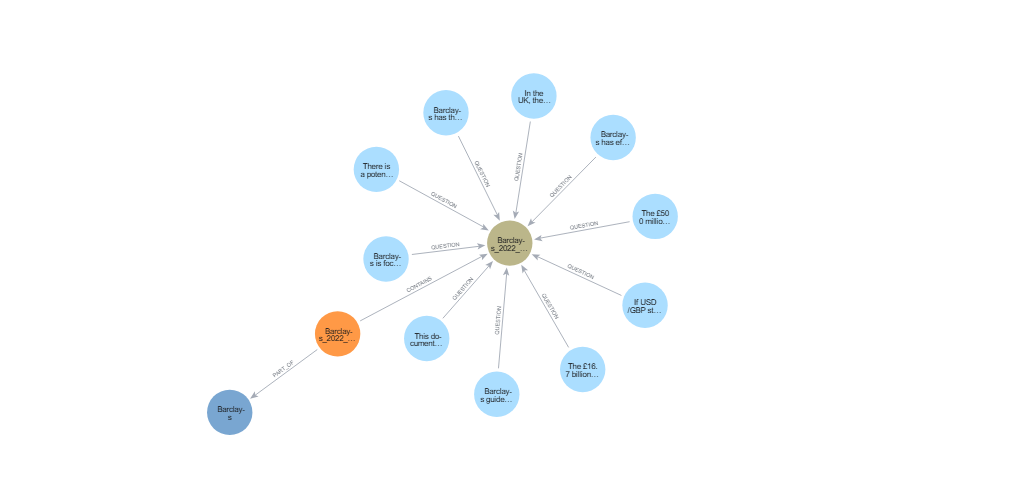

In [ ]:
from IPython.display import Image, display
display(Image(filename='barclays_graph_structure.png'))

# Appendix B: Metric Formulas



This appendix defines the retrieval-only metrics used in our evaluation, as implemented by the RAGAS framework.

### Context Recall

This measures how completely the retrieved contexts support the expected answer.

$$
\text{Recall} = \frac{\text{Number of claims in the reference supported by the retrieved context}}{\text{Total number of claims in the reference}}
$$

Interpretation:
- A recall of **1.00** means every expected claim in the ground truth was found in the retrieved contexts.
- A recall of **0.00** means none of the expected claims were supported.

In omission/negation cases, recall may reflect *non-contradiction* rather than factual presence (see §5.3.4).


### Context Precision@K

This measures how many of the retrieved contexts are genuinely relevant. It is **positionally weighted**, favouring relevant results ranked higher in the list.

$$
\text{Context Precision@K} = \frac{\sum_{k=1}^{K} (\text{Precision@k} \times v_k)}{\text{Total number of relevant items in the top K results}}
$$

Where:
- $K$ is the number of retrieved contexts (in our setup, $K = 15$ due to `TOP_K = 5` and `DOC_LIMIT = 3`)
- $v_k$ is a relevance weight assigned to the item at rank $k$
- $\text{Precision@k}$ is defined below


### Precision@k

Precision at each rank $k$ is computed as:

$$
\text{Precision@k} = \frac{\text{True Positives@k}}{\text{True Positives@k} + \text{False Positives@k}}
$$

Note:
- This formula collapses to a simpler ratio in many extractive QA tasks where relevance is binary.
- In our case, *all retrieved items are binary-labelled* (support or not), so `context_precision` directly reflects the fraction of relevant contexts.


# Appendix C: Model Failures and Evaluation Fragility Log



**Attempted Models & Outcomes**

| Attempt | Model         | Setup Details                                             | Result                  |
|--------:|---------------|-----------------------------------------------------------|--------------------------|
| 1       | gpt-5-mini    | `ChatOpenAI(model="gpt-5-mini")` + `LangchainLLMWrapper`  | Timed out after 300–600s |
| 2       | gpt-4         | Lowered concurrency (`RAGAS_MAX_WORKERS = 1`), wrapper kept | Timed out + 400 errors |
| 3       | gpt-4         | Monkey-patched `temperature = 1`                          | Wrapper re-injected 0.01 |
| 4       | gpt-4         | Wrapper removed, minimal setup                            | Some jobs ran, but fragile |
| ✅ 5     | gpt-3.5-turbo | No model specified (default fallback), no wrapper         | Ran successfully (~17s) |

**Common Errors**

- `TimeoutError` after ~3 minutes even with extended timeout.
- `400: Unsupported value: 'temperature' does not support 0.01` (from wrapper).
- Monkey-patching failed due to wrapper overrides.

---

**Scoring Fragility**

- RAGAS scored “not mentioned” answers as:
  - **Precision = 0.0** (answer not supported)
  - **Recall = 1.0** (no context required, so none missing)
- Compound answers penalised fully if any sub-part was unmatched.
- Ground truths required **exact phrasing** — valid paraphrases often scored as **false negatives**.

---

**Final Working Config (Used in Submission)**

- `evaluate(...)` with default RAGAS setup (→ gpt-3.5-turbo)
- No wrappers, no custom model
- `RAGAS_MAX_WORKERS = 1`
- No temp or retry params

# Appendix D: Files Referenced in the Notebook



The following files are directly used or referenced in this Notebook, including inputs, outputs, and visuals.

## 📁 visuals folder

```
📁 visuals
├── barclays20q_precision_recall_tau_06.png
├── barclays20q_precision_recall_tau_09.png
└── barclays_graph_structure.png
```

## 📁 results_rag_retrieval folder (condensed tree)

```
📁 results_rag_retrieval
│
├── 📁 barclays_20q
│   ├── README_barclays_20q.md
│   ├── 📁 input
│   │   ├── Barclays_2022_Q3_ResultsQA_Transcript.pdf
│   │   ├── Barclays_20_questions.xlsx
│   │   ├── 📁 tau_0.6_jsonl (barclays_20_input_tau_0.6.jsonl)
│   │   ├── 📁 tau_0.7_jsonl (barclays_20_input_tau_0.7.jsonl)
│   │   └── 📁 tau_0.9_jsonl (barclays_20_input_tau_0.9.jsonl)
│   │
│   ├── 📁 output_tau_0.6 (CSV, JSON, PNG, TXT, ragas_report.py)
│   ├── 📁 output_tau_0.7 (CSV, JSON, PNG, TXT, ragas_report.py)
│   ├── 📁 output_tau_0.9 (CSV, JSON, PNG, TXT, ragas_report.py)
│   │
│   ├── 📁 scripts_tau_0.6 (ragas_builder.py, ragas_eval.py, ragas_report.py)
│   ├── 📁 scripts_tau_0.7 (ragas_builder.py, ragas_eval.py, ragas_report.py)
│   └── 📁 scripts_tau_0.9 (ragas_builder.py, ragas_eval.py, ragas_report.py)
│
├── 📁 baseline_hsbc_q1
│   ├── HSBC_Q1_2025_transcript.pdf
│   ├── HSBC_Q1-12_questions.xlsx
│   ├── hsbc_q1_ragas_results_20250915_131518.csv / .json
│   ├── context_precision_recall_chart.png
│   ├── ragas_builder.py / ragas_eval.py / ragas_report.py
│   └── README_baseline_hsbc_q1.md
│
├── 📁 filter_logic_verification
│   ├── test_bank_filter_questions.xlsx
│   └── README.md
│
└── 📁 stress_testing
    ├── ragas_builder.py
    ├── ragas_eval.py
    ├── stress_test_ragas_input.jsonl
    ├── stress_test_ragas_results_20250926_151324.csv / .json
```